In [343]:
import numpy as np
import math
import random
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Part I
### Forward Simulation and Logistic Regression

**FORWARD SIMULATION**

In [344]:
alpha=0.9 # Probability parameter alpha in (0.5, 1) for P(Z|C)
beta=0.2  # Transition probability parameter for moving to and from parallel processing
gamma=0.1  # Transition probability parameter between states
lmda=(1, 5)  # Rate parameters for the Poisson distribution modeling spike counts under each attention state.

# Transition probability matrix for the HMM, parameterized by gamma and beta (Transition probabilities of switching between states C in {0, 1, 2}).
Gamma = np.array([[1-gamma, 0, gamma], [0, 1-gamma, gamma], [beta*0.5, beta*0.5, 1-beta]])
Z_prob = [[alpha, 1-alpha], [1-alpha, alpha], [0.5, 0.5]]

def forward_sim(n, T, alpha=0.9, gamma=0.1, beta=0.2, lmda=(1, 5)): 
    # Pre-defined (transition) probabilities
    Gamma = [[1-gamma, 0, gamma], [0, 1-gamma, gamma], [beta*0.5, beta*0.5, 1-beta]]
    

    # Initialize arrays
    C = np.zeros(T, dtype=int)
    Z = np.zeros((T, n), dtype=int)
    X = np.zeros((T, n), dtype=int)

    # Initial state
    C[0] = 2

    # Initialize X and Z for t=0
    for i in range(0, n):
            Z[0, i] = random.choices([0, 1], Z_prob[C[0]])[0]
            X[0, i] = np.random.poisson(lam = lmda[Z[0, i]])

    # Simulate the proces for the remaining t=1 to t=T timesteps
    for t in range(1, T):
        C[t] = random.choices([0, 1, 2], Gamma[C[t-1]])[0]
        for i in range(0, n):
            Z[t, i] = random.choices([0, 1], Z_prob[C[t]])[0]
            X[t, i] = np.random.poisson(lam = lmda[Z[t, i]])

    return C, Z, X

**VISUALIZATION**

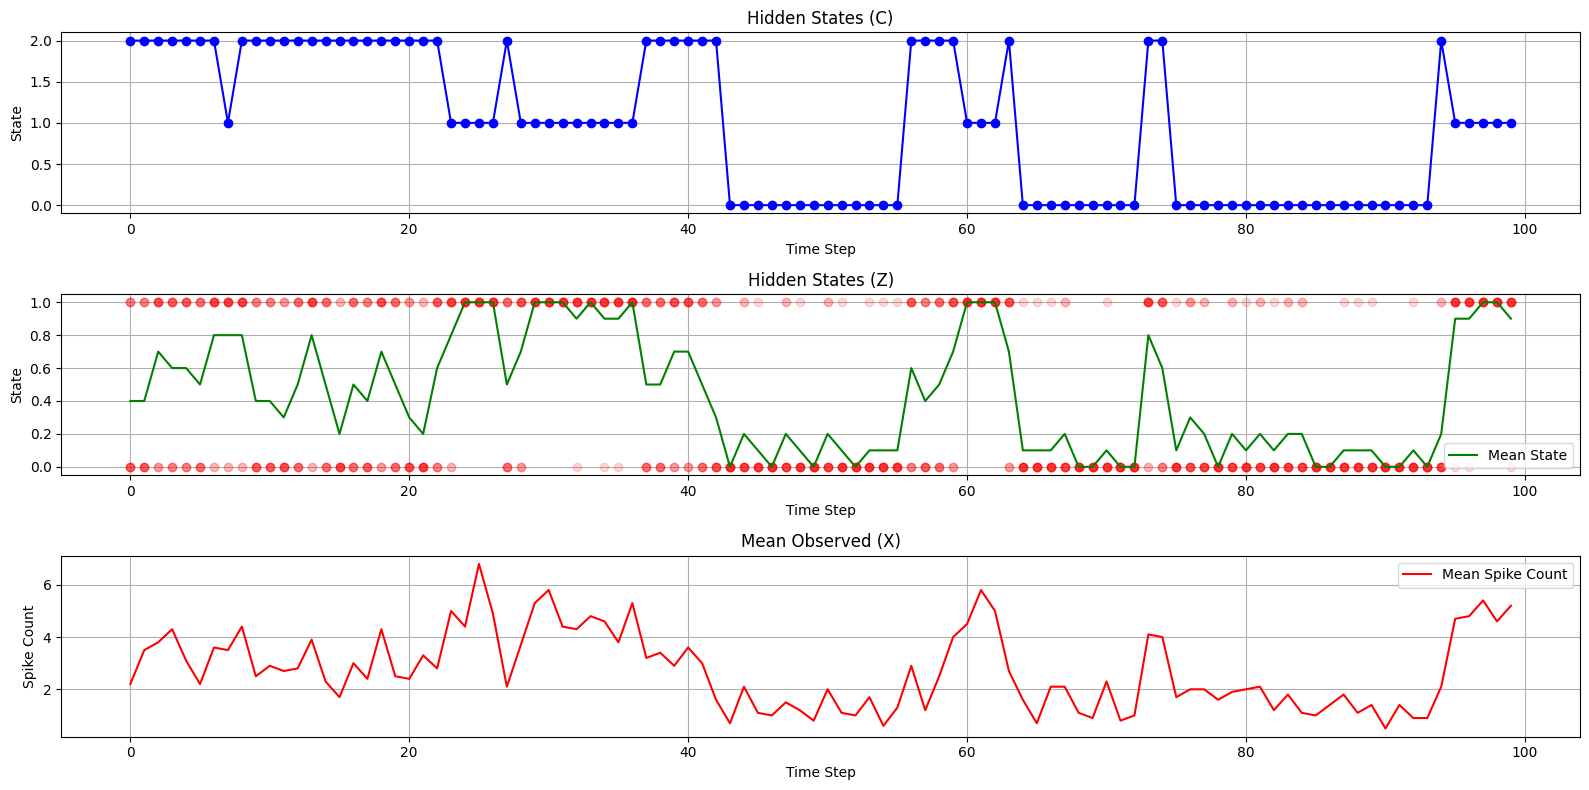

In [345]:
T = 100  # Time period
n = 10   # Number of neurons

C, Z, X = forward_sim(n, T)

#mean Z pr tid
avg_Z = np.mean(Z,axis=1).reshape(1,-1)[0]
avg_X = np.mean(X,axis=1).reshape(1,-1)[0]

# Visualize the data
plt.figure(figsize=(16, 8))

# Plot hidden states (C)
plt.subplot(3, 1, 1)
plt.plot(range(T), C, marker='o', color='blue')
plt.title('Hidden States (C)')
plt.xlabel('Time Step')
plt.ylabel('State')
plt.grid(True)

# Plot observed states (Z)
plt.subplot(3, 1, 2)
for i in range(n):
    plt.plot(range(T), Z[:, i], marker='o', alpha=1.5/n, color = 'red', linewidth = 0)
plt.plot(range(T), avg_Z, color='green', label = 'Mean State')
plt.title('Hidden States (Z)')
plt.xlabel('Time Step')
plt.ylabel('State')
plt.legend()
plt.grid(True)

# Plot observed states (X)
plt.subplot(3, 1, 3)
plt.plot(range(T), avg_X, color='red', label = 'Mean Spike Count')
plt.title('Mean Observed (X)')
plt.xlabel('Time Step')
plt.ylabel('Spike Count')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### MULTICLASS LOGISTIC REGRESSION 

In [346]:
# Split the date for validation
X_train, X_test, C_train, C_test = train_test_split(X, C, test_size=0.2, random_state=42)

# Assert shapes
assert(X_train.shape == (T-0.2*T, n))
assert(X_test.shape == (0.2*T, n))
assert(C_train.shape == (T-0.2*T, ))
assert(C_test.shape == (0.2*T, ))

In [347]:
# Train multinomial logistic regression using Scikit-Learn
LogReg = LogisticRegression(random_state=42, multi_class='multinomial')

LogReg.fit(X_train, C_train)
LogReg.score(X_test, C_test)

0.75

In [348]:
# Predict_proba essentially returns the CPD for P(C|X)
LogReg.predict_proba(X)

array([[6.92745837e-01, 4.87321814e-05, 3.07205430e-01],
       [2.22942440e-03, 7.20734608e-03, 9.90563230e-01],
       [4.48794685e-04, 1.76164046e-03, 9.97789565e-01],
       [8.63238449e-06, 6.95825702e-01, 3.04165665e-01],
       [7.43846289e-04, 2.76673063e-02, 9.71588847e-01],
       [2.65184929e-01, 4.08948678e-05, 7.34774176e-01],
       [6.27218809e-03, 2.69972242e-02, 9.66730588e-01],
       [2.27951697e-03, 3.35654923e-01, 6.62065560e-01],
       [1.76267102e-05, 5.45032784e-01, 4.54949589e-01],
       [2.64880083e-01, 4.23033784e-02, 6.92816539e-01],
       [4.21451756e-03, 4.70210939e-04, 9.95315271e-01],
       [3.90351874e-02, 7.82752974e-07, 9.60964030e-01],
       [9.62542460e-03, 1.13296528e-03, 9.89241610e-01],
       [9.94049405e-04, 1.63474901e-01, 8.35531050e-01],
       [1.74680270e-01, 2.58249468e-03, 8.22737235e-01],
       [5.82406006e-01, 1.63441360e-05, 4.17577650e-01],
       [5.10441376e-03, 2.47645016e-01, 7.47250570e-01],
       [9.07653548e-02, 1.00468

# Part II
### Inference algorithms, Testing Inference on Simulated Data

**INFERENCE OF Z**

In [349]:
def PX_given_Z(x, z, lmda=(1, 5)):
    return (np.exp(-1 * lmda[z]) * ((lmda[z]**x)/math.factorial(x)))

# Returns the answer to the query P(X=x|Z=z)

In [350]:
T = 100  # Time period
n = 10   # Number of neurons


C, Z, X = forward_sim(n, T)

In [351]:
#We assume that P(Z=0) = 0.5 due to the distribution of Z | C, and due to an assumption that P(C=1) = P(C=0)
Z_marg = (0.5, 0.5)


#We start by calculating P(X) for every observed X and save them in a table. It doesn't make sense to compute P(X) for unobserved values of X
X_marg = np.zeros(np.max(X)+1)
#We calculate P(X) using the formula: P(X=x) = P(X=x|Z=0)P(Z=0) + P(X=x|Z=1)P(Z=1)
#This works because Z ony takes values in {0,1}. We simply obtain the joint distribution P(X,Z) and sum out Z
for i in range(len(X_marg)):
    X_marg[i] = PX_given_Z(i, 0)*Z_marg[0] + PX_given_Z(i, 1)*Z_marg[1]


#X_marg[i] holds the answer for the query P(X=i)
#Likewise Z_marg[i] holds the answer for the query p(Z=i)
    

In [352]:
Z_inferred = np.zeros((T,n,2), dtype=float) 
#For every observed X=x, we calculate the conditional probaility P(Z=0|X=x)
#We use Bayes theorem to do this. 

for i in range(Z_inferred.shape[0]): 
    for j in range(Z_inferred.shape[1]): 
        Z_inferred[i,j,0] = (PX_given_Z(X[i,j], 0)*Z_marg[0])/(X_marg[X[i,j]])
        Z_inferred[i,j,1] = 1 - Z_inferred[i,j,0] 


In [353]:
def PZ_given_C(c, z, alpha=0.9):
    Z_prob = np.array([[alpha, 1-alpha], [1-alpha, alpha], [0.5, 0.5]])
    return Z_prob[c, z]

### Forward Algorithm

In [354]:
def calc_emission_proba(t: int, c: int) -> float:
    """
    Calculates the emission probabilities at timestep t
    The probabilities given by P(X_1,t...X_n,t|C_t)
    P(Z|C) by function PZ_given_C(c, z)
    P(X|Z) Poisson distribution given by PX_given_Z(x, z)
    """
    emission_proba = 0.
    for i in range(n):
        emission_proba += np.log(PZ_given_C(c, 0)*PX_given_Z(X[t, i], 0) + PZ_given_C(c, 1)*PX_given_Z(X[t, i], 1))
    emission_proba = np.exp(emission_proba)
    return emission_proba

In [355]:
def forward():
    """
    Iteratively updates the Alpha_t vectors in the Alpha matrix.
    The Alpha matrix represents the P(C|X) distribution for each timestep T as an T x 3 matrix.
    """
    # Initialization of the forward probabilities matrix, Alpha.
    Alpha = np.zeros((T, 3), dtype=float)  # T x 3 matrix P(C|X)
    Alpha[0, 2] = 1.  # Assumed state C_0=2 becomes our Alpha_0 vector (Alpha_0=[0, 0, 1])
    for t in range(1, T):
        for c in range(3):
            c_prev = 0. # For calculating SUM_c_t-1 P(C_t|c_t-1)*Alpha_t-1(c_t-1)
            for c_ in range(3):
                c_prev += Gamma[c_, c]*Alpha[t-1, c_]
            Alpha[t, c] = calc_emission_proba(t, c)*c_prev # Alpha_t = P(X_1,t,...,X_n,t|C_t) * SUM_c_t-1 P(C_t|c_t-1)*Alpha_t-1(c_t-1)
        row_sum = np.sum(Alpha[t], axis=0) # Normalizing sum for each row
        Alpha[t] = Alpha[t]/row_sum # Row-wise normalization for the CPD, normalizing the unnormalized Gibbs measure of each row.
    return Alpha

**CONFIDENCE AGAINST SIMULATED DATA**

In [356]:
C_inferred = forward() 
def calc_confidence_of_C(infered_C, true_C):
    Confidence = np.zeros(len(true_C), dtype = float)
    for c in true_C: 
        for t in range(0, len(true_C)): 
            Confidence[t] = infered_C[t, true_C[t]]
    return np.average(Confidence)

In [357]:
def calc_confidence_of_Z(inferred_Z, true_Z):
    Confidence = np.zeros((true_Z.shape[0],true_Z.shape[1]), dtype = float)
    for t in range(0,true_Z.shape[0]): 
        for n in range(0, true_Z.shape[1]): 
            Confidence[t,n] = inferred_Z[t,n,[true_Z[t,n]]]
    return np.average(Confidence)


**VISUALIZING CONFIDENCE**

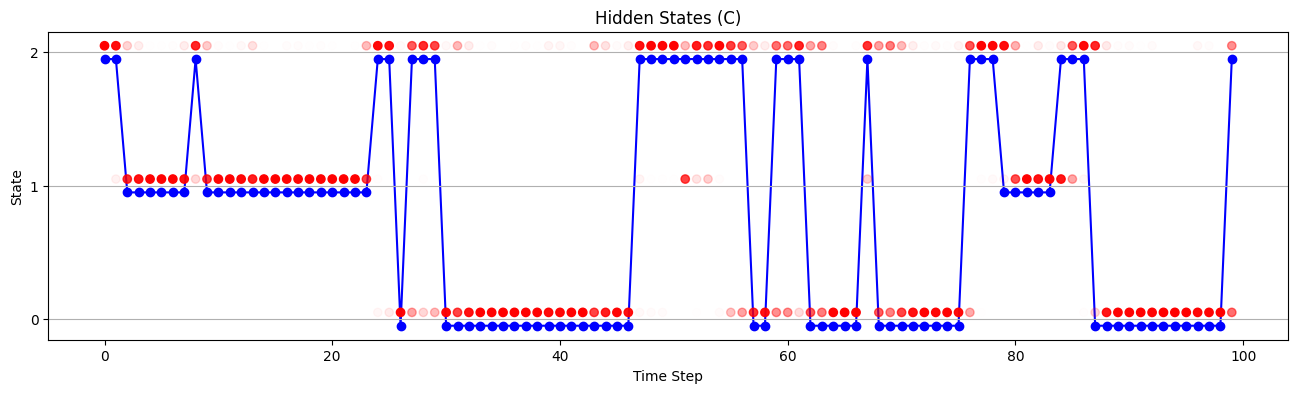

In [383]:
plt.figure(figsize=(16, 4))
# Plot hidden states (C)
for i in range(3):  # Iterate over possible values 0, 1, 2
    plt.scatter(range(T), [i+0.05] * T,  c='red', alpha=C_inferred[:, i])
plt.plot(range(T), C-0.05, marker='o', color='blue', zorder = 0)
plt.title('Hidden States (C)')
plt.xlabel('Time Step')
plt.ylabel('State')
plt.yticks([0, 1, 2])
plt.grid(True, axis='y')  # Only grid lines on the y-axis
